# Airline

In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils



Using TensorFlow backend.
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\programfiles\python37\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# %%
#Normalization  
def feature_normalize(train):
    train_norm = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))  #標準化(介於0~1之間)
    return train_norm


## 很重要  切割視窗
def create_segments_and_labels(df, time_steps, step):

    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps-1, step):
        xs = df.values[i: i + time_steps]
        rate = (df.values[i + time_steps]-df.values[i + time_steps-1])/df.values[i + time_steps-1]
        #rate = df.values[i + time_steps]-df.values[i + time_steps-1]
        temp = rate
        if temp < 0:
            if temp <= -0.2:
                label =0
            elif temp <= -0.1:
                label =1
            elif temp < 0:
                label =2
        else:
            if temp == 0:
                label =3
            elif temp <= 0.1:
                label =4
            elif temp <= 0.2:
                label =5                
            elif temp >0.2:
                label =6              
 
        segments.append([xs])
        labels.append([label])#要會自己寫

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels



In [3]:
# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# The number of steps within one time segment
TIME_PERIODS = 12
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 1

# %%

print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = pd.read_csv('D:/Value of Dream/108-1 深度學習/Deep Learning Tool/Data/airline.csv',encoding='Big5')    #編碼為Big5
cols=['passenger']       #命名欄位
df =df[cols]                                      #將欄位名稱放入資料中          


# %%

print("\n--- Reshape the data into segments ---\n")

# Normalize features for training data set
df_train= feature_normalize(df)#只有一行

x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE)
# TIME_PERIODS = 1，STEP_DISTANCE = 1 往前下一筆
# %%

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')

print('y_train shape: ', y_train.shape)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = 7


# Set input_shape / reshape for Keras
input_shape = (num_time_periods*num_sensors)   
x_train = x_train.reshape(x_train.shape[0], input_shape)   

print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# %%

# One-hot encoding of y_train labels (only execute once!)
y_train_oneshot = np_utils.to_categorical(y_train, num_classes)


## 分成訓練跟測試
x_train_used = x_train[0:120,]
y_train_used_oneshot = y_train_oneshot[0:120,]
x_test_used = x_train[121:,]
y_test_used_oneshot = y_train_oneshot[121:,]

print("\n--- Create neural network model ---\n")





--- Load, inspect and transform data ---


--- Reshape the data into segments ---


--- Reshape data to be accepted by Keras ---

x_train shape:  (131, 12, 1)
131 training samples
y_train shape:  (131, 1)
x_train shape: (131, 12)
input_shape: 12

--- Create neural network model ---



In [4]:

######################################################
from keras.models import Sequential
from keras.layers import Dense


# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))  
model_m.add(Conv1D(150, 2, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(150, 2, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 2, activation='relu'))
model_m.add(Conv1D(160, 2, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

# %%

print("\n--- Fit the model ---\n")

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])


# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
train_history = model_m.fit(x=x_train_used, y= y_train_used_oneshot, validation_split=0.2, epochs=1500, batch_size=10, verbose=2)

# %%

print("\n--- Learning curve of model training ---\n")

get_ipython().magic('matplotlib inline')
## IPython有一組預先定義好的所謂的魔法函數（Magic Functions），你可以通過命令列的語法形式來訪問它們。


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 12, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 150)           450       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 150)           45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 150)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 160)            48160     
_________________________________________________________________
conv1d_4 (Conv1D)    

Epoch 68/1500
 - 0s - loss: 1.1099 - acc: 0.5313 - val_loss: 1.0646 - val_acc: 0.6667
Epoch 69/1500
 - 0s - loss: 1.0045 - acc: 0.6146 - val_loss: 0.9981 - val_acc: 0.6667
Epoch 70/1500
 - 0s - loss: 1.0719 - acc: 0.5729 - val_loss: 0.9991 - val_acc: 0.6667
Epoch 71/1500
 - 0s - loss: 1.0764 - acc: 0.5625 - val_loss: 1.0169 - val_acc: 0.6250
Epoch 72/1500
 - 0s - loss: 1.0512 - acc: 0.5521 - val_loss: 1.0715 - val_acc: 0.5833
Epoch 73/1500
 - 0s - loss: 1.0340 - acc: 0.6042 - val_loss: 1.0957 - val_acc: 0.6667
Epoch 74/1500
 - 0s - loss: 1.0414 - acc: 0.5521 - val_loss: 1.0356 - val_acc: 0.5833
Epoch 75/1500
 - 0s - loss: 1.0005 - acc: 0.5313 - val_loss: 0.9509 - val_acc: 0.6667
Epoch 76/1500
 - 0s - loss: 0.9479 - acc: 0.6354 - val_loss: 1.0701 - val_acc: 0.6667
Epoch 77/1500
 - 0s - loss: 1.0388 - acc: 0.5729 - val_loss: 1.1005 - val_acc: 0.7083
Epoch 78/1500
 - 0s - loss: 1.0397 - acc: 0.5729 - val_loss: 0.9984 - val_acc: 0.6667
Epoch 79/1500
 - 0s - loss: 0.9767 - acc: 0.5938 - val

Epoch 163/1500
 - 0s - loss: 0.3195 - acc: 0.8958 - val_loss: 2.0052 - val_acc: 0.6667
Epoch 164/1500
 - 0s - loss: 0.3244 - acc: 0.8750 - val_loss: 1.8710 - val_acc: 0.7500
Epoch 165/1500
 - 0s - loss: 0.3737 - acc: 0.8646 - val_loss: 1.9520 - val_acc: 0.7083
Epoch 166/1500
 - 0s - loss: 0.3915 - acc: 0.8646 - val_loss: 2.2923 - val_acc: 0.7083
Epoch 167/1500
 - 0s - loss: 0.4488 - acc: 0.8125 - val_loss: 1.9972 - val_acc: 0.7083
Epoch 168/1500
 - 0s - loss: 0.3335 - acc: 0.8437 - val_loss: 1.9844 - val_acc: 0.6250
Epoch 169/1500
 - 0s - loss: 0.2874 - acc: 0.9062 - val_loss: 2.0654 - val_acc: 0.6667
Epoch 170/1500
 - 0s - loss: 0.3248 - acc: 0.8750 - val_loss: 1.8568 - val_acc: 0.6667
Epoch 171/1500
 - 0s - loss: 0.2913 - acc: 0.9167 - val_loss: 1.9644 - val_acc: 0.7083
Epoch 172/1500
 - 0s - loss: 0.3404 - acc: 0.8542 - val_loss: 1.6764 - val_acc: 0.7083
Epoch 173/1500
 - 0s - loss: 0.3949 - acc: 0.8229 - val_loss: 1.9432 - val_acc: 0.6250
Epoch 174/1500
 - 0s - loss: 0.3725 - acc: 

 - 0s - loss: 0.1409 - acc: 0.9479 - val_loss: 2.4236 - val_acc: 0.7500
Epoch 258/1500
 - 0s - loss: 0.1327 - acc: 0.9375 - val_loss: 2.1635 - val_acc: 0.7083
Epoch 259/1500
 - 0s - loss: 0.1958 - acc: 0.9167 - val_loss: 2.7176 - val_acc: 0.7083
Epoch 260/1500
 - 0s - loss: 0.2333 - acc: 0.9167 - val_loss: 2.2422 - val_acc: 0.7500
Epoch 261/1500
 - 0s - loss: 0.1499 - acc: 0.9479 - val_loss: 2.5495 - val_acc: 0.7083
Epoch 262/1500
 - 0s - loss: 0.1657 - acc: 0.9375 - val_loss: 2.7324 - val_acc: 0.7083
Epoch 263/1500
 - 0s - loss: 0.1421 - acc: 0.9375 - val_loss: 2.0910 - val_acc: 0.7917
Epoch 264/1500
 - 0s - loss: 0.1350 - acc: 0.9583 - val_loss: 2.5694 - val_acc: 0.7500
Epoch 265/1500
 - 0s - loss: 0.1618 - acc: 0.9479 - val_loss: 2.5634 - val_acc: 0.7500
Epoch 266/1500
 - 0s - loss: 0.1674 - acc: 0.9271 - val_loss: 2.5000 - val_acc: 0.7917
Epoch 267/1500
 - 0s - loss: 0.1323 - acc: 0.9479 - val_loss: 2.0242 - val_acc: 0.8333
Epoch 268/1500
 - 0s - loss: 0.1978 - acc: 0.9375 - val_lo

Epoch 352/1500
 - 0s - loss: 0.1476 - acc: 0.9375 - val_loss: 2.6444 - val_acc: 0.7083
Epoch 353/1500
 - 0s - loss: 0.1341 - acc: 0.9583 - val_loss: 2.4151 - val_acc: 0.7500
Epoch 354/1500
 - 0s - loss: 0.1092 - acc: 0.9375 - val_loss: 2.1469 - val_acc: 0.7917
Epoch 355/1500
 - 0s - loss: 0.0934 - acc: 0.9479 - val_loss: 2.2969 - val_acc: 0.7917
Epoch 356/1500
 - 0s - loss: 0.1334 - acc: 0.9167 - val_loss: 2.4175 - val_acc: 0.8333
Epoch 357/1500
 - 0s - loss: 0.1074 - acc: 0.9583 - val_loss: 2.5946 - val_acc: 0.7917
Epoch 358/1500
 - 0s - loss: 0.1364 - acc: 0.9271 - val_loss: 2.6065 - val_acc: 0.7917
Epoch 359/1500
 - 0s - loss: 0.1249 - acc: 0.9479 - val_loss: 2.6425 - val_acc: 0.7917
Epoch 360/1500
 - 0s - loss: 0.1631 - acc: 0.9167 - val_loss: 2.5239 - val_acc: 0.7917
Epoch 361/1500
 - 0s - loss: 0.1102 - acc: 0.9583 - val_loss: 2.6327 - val_acc: 0.7500
Epoch 362/1500
 - 0s - loss: 0.1342 - acc: 0.9479 - val_loss: 2.7786 - val_acc: 0.7500
Epoch 363/1500
 - 0s - loss: 0.1206 - acc: 

 - 0s - loss: 0.0791 - acc: 0.9687 - val_loss: 2.3279 - val_acc: 0.8333
Epoch 447/1500
 - 0s - loss: 0.0444 - acc: 1.0000 - val_loss: 2.3697 - val_acc: 0.8333
Epoch 448/1500
 - 0s - loss: 0.0802 - acc: 0.9792 - val_loss: 2.3478 - val_acc: 0.8333
Epoch 449/1500
 - 0s - loss: 0.0435 - acc: 0.9896 - val_loss: 2.3340 - val_acc: 0.8333
Epoch 450/1500
 - 0s - loss: 0.0550 - acc: 0.9896 - val_loss: 2.2742 - val_acc: 0.8333
Epoch 451/1500
 - 0s - loss: 0.0967 - acc: 0.9687 - val_loss: 2.4207 - val_acc: 0.7917
Epoch 452/1500
 - 0s - loss: 0.0518 - acc: 0.9896 - val_loss: 2.4017 - val_acc: 0.7917
Epoch 453/1500
 - 0s - loss: 0.0657 - acc: 0.9687 - val_loss: 2.2285 - val_acc: 0.8333
Epoch 454/1500
 - 0s - loss: 0.1647 - acc: 0.9271 - val_loss: 2.4998 - val_acc: 0.7500
Epoch 455/1500
 - 0s - loss: 0.0420 - acc: 0.9792 - val_loss: 2.5021 - val_acc: 0.7917
Epoch 456/1500
 - 0s - loss: 0.0830 - acc: 0.9896 - val_loss: 2.4414 - val_acc: 0.7917
Epoch 457/1500
 - 0s - loss: 0.0509 - acc: 0.9896 - val_lo

Epoch 541/1500
 - 0s - loss: 0.0844 - acc: 0.9792 - val_loss: 2.2228 - val_acc: 0.8333
Epoch 542/1500
 - 0s - loss: 0.0643 - acc: 0.9896 - val_loss: 2.3759 - val_acc: 0.7500
Epoch 543/1500
 - 0s - loss: 0.0428 - acc: 0.9896 - val_loss: 2.2892 - val_acc: 0.8333
Epoch 544/1500
 - 0s - loss: 0.0744 - acc: 0.9792 - val_loss: 2.3656 - val_acc: 0.8333
Epoch 545/1500
 - 0s - loss: 0.0829 - acc: 0.9688 - val_loss: 2.0740 - val_acc: 0.8333
Epoch 546/1500
 - 0s - loss: 0.0867 - acc: 0.9792 - val_loss: 2.2909 - val_acc: 0.7917
Epoch 547/1500
 - 0s - loss: 0.0447 - acc: 0.9896 - val_loss: 2.1879 - val_acc: 0.7917
Epoch 548/1500
 - 0s - loss: 0.0720 - acc: 0.9687 - val_loss: 2.2455 - val_acc: 0.8333
Epoch 549/1500
 - 0s - loss: 0.0671 - acc: 0.9583 - val_loss: 2.3424 - val_acc: 0.7917
Epoch 550/1500
 - 0s - loss: 0.0673 - acc: 0.9687 - val_loss: 2.2797 - val_acc: 0.8333
Epoch 551/1500
 - 0s - loss: 0.0282 - acc: 1.0000 - val_loss: 2.3012 - val_acc: 0.7917
Epoch 552/1500
 - 0s - loss: 0.0504 - acc: 

Epoch 636/1500
 - 0s - loss: 0.0373 - acc: 1.0000 - val_loss: 2.4807 - val_acc: 0.8333
Epoch 637/1500
 - 0s - loss: 0.0665 - acc: 0.9583 - val_loss: 2.4918 - val_acc: 0.8333
Epoch 638/1500
 - 0s - loss: 0.0226 - acc: 1.0000 - val_loss: 2.4633 - val_acc: 0.7917
Epoch 639/1500
 - 0s - loss: 0.0219 - acc: 1.0000 - val_loss: 2.4943 - val_acc: 0.8333
Epoch 640/1500
 - 0s - loss: 0.0797 - acc: 0.9896 - val_loss: 2.5315 - val_acc: 0.8333
Epoch 641/1500
 - 0s - loss: 0.0562 - acc: 0.9792 - val_loss: 2.3900 - val_acc: 0.8333
Epoch 642/1500
 - 0s - loss: 0.0621 - acc: 0.9792 - val_loss: 2.5210 - val_acc: 0.7917
Epoch 643/1500
 - 0s - loss: 0.0880 - acc: 0.9479 - val_loss: 2.7046 - val_acc: 0.7917
Epoch 644/1500
 - 0s - loss: 0.0639 - acc: 0.9792 - val_loss: 2.7694 - val_acc: 0.7917
Epoch 645/1500
 - 0s - loss: 0.0422 - acc: 0.9792 - val_loss: 2.8002 - val_acc: 0.7500
Epoch 646/1500
 - 0s - loss: 0.0399 - acc: 0.9896 - val_loss: 2.7160 - val_acc: 0.7500
Epoch 647/1500
 - 0s - loss: 0.0872 - acc: 

 - 0s - loss: 0.0497 - acc: 0.9896 - val_loss: 2.5441 - val_acc: 0.8333
Epoch 731/1500
 - 0s - loss: 0.0514 - acc: 0.9792 - val_loss: 2.5036 - val_acc: 0.7917
Epoch 732/1500
 - 0s - loss: 0.0160 - acc: 1.0000 - val_loss: 2.5113 - val_acc: 0.8333
Epoch 733/1500
 - 0s - loss: 0.0293 - acc: 0.9896 - val_loss: 2.5988 - val_acc: 0.8333
Epoch 734/1500
 - 0s - loss: 0.0608 - acc: 0.9583 - val_loss: 2.6926 - val_acc: 0.8333
Epoch 735/1500
 - 0s - loss: 0.0387 - acc: 0.9896 - val_loss: 2.7089 - val_acc: 0.8333
Epoch 736/1500
 - 0s - loss: 0.0627 - acc: 0.9687 - val_loss: 2.7290 - val_acc: 0.7917
Epoch 737/1500
 - 0s - loss: 0.0386 - acc: 0.9792 - val_loss: 2.6107 - val_acc: 0.8333
Epoch 738/1500
 - 0s - loss: 0.0367 - acc: 0.9896 - val_loss: 2.6107 - val_acc: 0.8333
Epoch 739/1500
 - 0s - loss: 0.0713 - acc: 0.9583 - val_loss: 2.3774 - val_acc: 0.8333
Epoch 740/1500
 - 0s - loss: 0.0525 - acc: 0.9792 - val_loss: 2.6568 - val_acc: 0.7917
Epoch 741/1500
 - 0s - loss: 0.0496 - acc: 0.9896 - val_lo

Epoch 825/1500
 - 0s - loss: 0.0498 - acc: 0.9792 - val_loss: 2.7052 - val_acc: 0.8333
Epoch 826/1500
 - 0s - loss: 0.0227 - acc: 1.0000 - val_loss: 2.6478 - val_acc: 0.7917
Epoch 827/1500
 - 0s - loss: 0.0476 - acc: 0.9896 - val_loss: 2.6563 - val_acc: 0.7917
Epoch 828/1500
 - 0s - loss: 0.0118 - acc: 1.0000 - val_loss: 2.7769 - val_acc: 0.7917
Epoch 829/1500
 - 0s - loss: 0.0210 - acc: 0.9896 - val_loss: 2.6457 - val_acc: 0.8333
Epoch 830/1500
 - 0s - loss: 0.0553 - acc: 0.9792 - val_loss: 2.7431 - val_acc: 0.7917
Epoch 831/1500
 - 0s - loss: 0.0585 - acc: 0.9583 - val_loss: 2.8721 - val_acc: 0.7917
Epoch 832/1500
 - 0s - loss: 0.0466 - acc: 0.9896 - val_loss: 2.6781 - val_acc: 0.7917
Epoch 833/1500
 - 0s - loss: 0.0375 - acc: 0.9896 - val_loss: 2.6318 - val_acc: 0.7500
Epoch 834/1500
 - 0s - loss: 0.0154 - acc: 1.0000 - val_loss: 2.6553 - val_acc: 0.7917
Epoch 835/1500
 - 0s - loss: 0.0506 - acc: 0.9896 - val_loss: 2.7196 - val_acc: 0.7500
Epoch 836/1500
 - 0s - loss: 0.0295 - acc: 

 - 0s - loss: 0.0450 - acc: 0.9792 - val_loss: 2.6825 - val_acc: 0.8333
Epoch 920/1500
 - 0s - loss: 0.0292 - acc: 0.9896 - val_loss: 2.6882 - val_acc: 0.8333
Epoch 921/1500
 - 0s - loss: 0.0249 - acc: 1.0000 - val_loss: 2.5452 - val_acc: 0.8333
Epoch 922/1500
 - 0s - loss: 0.0672 - acc: 0.9687 - val_loss: 2.6575 - val_acc: 0.7917
Epoch 923/1500
 - 0s - loss: 0.0881 - acc: 0.9792 - val_loss: 2.8531 - val_acc: 0.7500
Epoch 924/1500
 - 0s - loss: 0.0803 - acc: 0.9479 - val_loss: 2.7098 - val_acc: 0.7500
Epoch 925/1500
 - 0s - loss: 0.0460 - acc: 0.9792 - val_loss: 2.5525 - val_acc: 0.7500
Epoch 926/1500
 - 0s - loss: 0.0556 - acc: 0.9687 - val_loss: 2.5629 - val_acc: 0.7500
Epoch 927/1500
 - 0s - loss: 0.0347 - acc: 0.9896 - val_loss: 2.7122 - val_acc: 0.7917
Epoch 928/1500
 - 0s - loss: 0.0313 - acc: 0.9792 - val_loss: 2.7852 - val_acc: 0.7917
Epoch 929/1500
 - 0s - loss: 0.0269 - acc: 0.9896 - val_loss: 2.7341 - val_acc: 0.7917
Epoch 930/1500
 - 0s - loss: 0.0514 - acc: 0.9687 - val_lo

Epoch 1014/1500
 - 0s - loss: 0.0147 - acc: 1.0000 - val_loss: 2.7173 - val_acc: 0.8333
Epoch 1015/1500
 - 0s - loss: 0.0147 - acc: 1.0000 - val_loss: 2.7127 - val_acc: 0.8333
Epoch 1016/1500
 - 0s - loss: 0.0250 - acc: 1.0000 - val_loss: 2.7022 - val_acc: 0.8333
Epoch 1017/1500
 - 0s - loss: 0.0378 - acc: 0.9896 - val_loss: 2.6817 - val_acc: 0.8333
Epoch 1018/1500
 - 0s - loss: 0.0221 - acc: 0.9896 - val_loss: 2.6738 - val_acc: 0.7917
Epoch 1019/1500
 - 0s - loss: 0.0302 - acc: 0.9896 - val_loss: 2.6962 - val_acc: 0.8333
Epoch 1020/1500
 - 0s - loss: 0.0080 - acc: 1.0000 - val_loss: 2.6951 - val_acc: 0.8333
Epoch 1021/1500
 - 0s - loss: 0.0290 - acc: 0.9896 - val_loss: 2.7025 - val_acc: 0.8333
Epoch 1022/1500
 - 0s - loss: 0.0308 - acc: 0.9792 - val_loss: 2.7069 - val_acc: 0.8333
Epoch 1023/1500
 - 0s - loss: 0.0243 - acc: 0.9792 - val_loss: 2.7142 - val_acc: 0.8333
Epoch 1024/1500
 - 0s - loss: 0.0368 - acc: 0.9896 - val_loss: 2.7934 - val_acc: 0.7917
Epoch 1025/1500
 - 0s - loss: 0.

Epoch 1108/1500
 - 0s - loss: 0.0534 - acc: 0.9792 - val_loss: 2.7592 - val_acc: 0.7500
Epoch 1109/1500
 - 0s - loss: 0.0448 - acc: 0.9687 - val_loss: 2.7560 - val_acc: 0.7500
Epoch 1110/1500
 - 0s - loss: 0.0441 - acc: 0.9792 - val_loss: 2.7296 - val_acc: 0.7917
Epoch 1111/1500
 - 0s - loss: 0.0471 - acc: 0.9896 - val_loss: 2.6834 - val_acc: 0.7917
Epoch 1112/1500
 - 0s - loss: 0.0333 - acc: 0.9792 - val_loss: 2.6457 - val_acc: 0.7917
Epoch 1113/1500
 - 0s - loss: 0.0204 - acc: 0.9896 - val_loss: 2.6276 - val_acc: 0.7500
Epoch 1114/1500
 - 0s - loss: 0.0279 - acc: 0.9896 - val_loss: 2.6334 - val_acc: 0.7500
Epoch 1115/1500
 - 0s - loss: 0.0281 - acc: 0.9792 - val_loss: 2.6512 - val_acc: 0.7917
Epoch 1116/1500
 - 0s - loss: 0.0372 - acc: 0.9792 - val_loss: 2.6802 - val_acc: 0.8333
Epoch 1117/1500
 - 0s - loss: 0.0415 - acc: 0.9792 - val_loss: 2.6567 - val_acc: 0.7917
Epoch 1118/1500
 - 0s - loss: 0.0225 - acc: 1.0000 - val_loss: 2.6520 - val_acc: 0.7917
Epoch 1119/1500
 - 0s - loss: 0.

Epoch 1202/1500
 - 0s - loss: 0.0059 - acc: 1.0000 - val_loss: 2.7191 - val_acc: 0.8333
Epoch 1203/1500
 - 0s - loss: 0.0144 - acc: 1.0000 - val_loss: 2.7048 - val_acc: 0.8333
Epoch 1204/1500
 - 0s - loss: 0.0301 - acc: 0.9896 - val_loss: 2.7023 - val_acc: 0.8333
Epoch 1205/1500
 - 0s - loss: 0.0555 - acc: 0.9792 - val_loss: 3.2570 - val_acc: 0.7083
Epoch 1206/1500
 - 0s - loss: 0.0813 - acc: 0.9792 - val_loss: 2.6941 - val_acc: 0.8333
Epoch 1207/1500
 - 0s - loss: 0.0774 - acc: 0.9792 - val_loss: 2.8981 - val_acc: 0.7917
Epoch 1208/1500
 - 0s - loss: 0.0561 - acc: 0.9896 - val_loss: 2.6995 - val_acc: 0.8333
Epoch 1209/1500
 - 0s - loss: 0.0327 - acc: 0.9792 - val_loss: 2.7102 - val_acc: 0.8333
Epoch 1210/1500
 - 0s - loss: 0.0428 - acc: 0.9896 - val_loss: 2.6995 - val_acc: 0.8333
Epoch 1211/1500
 - 0s - loss: 0.0145 - acc: 0.9896 - val_loss: 2.6990 - val_acc: 0.8333
Epoch 1212/1500
 - 0s - loss: 0.0135 - acc: 1.0000 - val_loss: 2.7057 - val_acc: 0.8333
Epoch 1213/1500
 - 0s - loss: 0.

Epoch 1296/1500
 - 0s - loss: 0.0225 - acc: 0.9896 - val_loss: 2.6127 - val_acc: 0.8333
Epoch 1297/1500
 - 0s - loss: 0.0197 - acc: 0.9896 - val_loss: 2.5900 - val_acc: 0.8333
Epoch 1298/1500
 - 0s - loss: 0.0488 - acc: 0.9792 - val_loss: 2.6203 - val_acc: 0.8333
Epoch 1299/1500
 - 0s - loss: 0.0389 - acc: 0.9792 - val_loss: 2.6922 - val_acc: 0.8333
Epoch 1300/1500
 - 0s - loss: 0.0424 - acc: 0.9792 - val_loss: 2.6954 - val_acc: 0.8333
Epoch 1301/1500
 - 0s - loss: 0.0432 - acc: 0.9687 - val_loss: 3.2359 - val_acc: 0.7083
Epoch 1302/1500
 - 0s - loss: 0.0312 - acc: 0.9896 - val_loss: 2.7456 - val_acc: 0.7917
Epoch 1303/1500
 - 0s - loss: 0.0788 - acc: 0.9687 - val_loss: 2.6870 - val_acc: 0.8333
Epoch 1304/1500
 - 0s - loss: 0.0115 - acc: 1.0000 - val_loss: 2.6866 - val_acc: 0.8333
Epoch 1305/1500
 - 0s - loss: 0.0527 - acc: 0.9687 - val_loss: 2.6966 - val_acc: 0.8333
Epoch 1306/1500
 - 0s - loss: 0.0295 - acc: 0.9896 - val_loss: 2.6893 - val_acc: 0.8333
Epoch 1307/1500
 - 0s - loss: 0.

Epoch 1390/1500
 - 0s - loss: 0.0512 - acc: 0.9687 - val_loss: 2.7767 - val_acc: 0.7917
Epoch 1391/1500
 - 0s - loss: 0.0300 - acc: 0.9896 - val_loss: 2.6900 - val_acc: 0.8333
Epoch 1392/1500
 - 0s - loss: 0.1349 - acc: 0.9792 - val_loss: 2.6880 - val_acc: 0.8333
Epoch 1393/1500
 - 0s - loss: 0.0438 - acc: 0.9896 - val_loss: 2.6932 - val_acc: 0.8333
Epoch 1394/1500
 - 0s - loss: 0.0277 - acc: 0.9896 - val_loss: 2.6929 - val_acc: 0.8333
Epoch 1395/1500
 - 0s - loss: 0.0097 - acc: 1.0000 - val_loss: 2.7145 - val_acc: 0.8333
Epoch 1396/1500
 - 0s - loss: 0.0399 - acc: 0.9687 - val_loss: 2.7555 - val_acc: 0.7917
Epoch 1397/1500
 - 0s - loss: 0.1381 - acc: 0.9792 - val_loss: 2.9457 - val_acc: 0.7500
Epoch 1398/1500
 - 0s - loss: 0.0428 - acc: 0.9792 - val_loss: 2.8264 - val_acc: 0.7500
Epoch 1399/1500
 - 0s - loss: 0.1329 - acc: 0.9583 - val_loss: 4.4863 - val_acc: 0.6250
Epoch 1400/1500
 - 0s - loss: 0.2129 - acc: 0.9375 - val_loss: 2.7580 - val_acc: 0.7917
Epoch 1401/1500
 - 0s - loss: 0.

Epoch 1484/1500
 - 0s - loss: 0.0365 - acc: 0.9896 - val_loss: 3.2338 - val_acc: 0.7500
Epoch 1485/1500
 - 0s - loss: 0.1539 - acc: 0.9479 - val_loss: 3.2839 - val_acc: 0.6250
Epoch 1486/1500
 - 0s - loss: 0.0917 - acc: 0.9792 - val_loss: 3.3240 - val_acc: 0.6667
Epoch 1487/1500
 - 0s - loss: 0.0342 - acc: 0.9896 - val_loss: 2.9459 - val_acc: 0.7083
Epoch 1488/1500
 - 0s - loss: 0.0825 - acc: 0.9687 - val_loss: 2.8740 - val_acc: 0.7917
Epoch 1489/1500
 - 0s - loss: 0.0230 - acc: 0.9896 - val_loss: 2.9338 - val_acc: 0.7500
Epoch 1490/1500
 - 0s - loss: 0.0201 - acc: 0.9896 - val_loss: 2.8644 - val_acc: 0.7500
Epoch 1491/1500
 - 0s - loss: 0.0308 - acc: 0.9896 - val_loss: 2.8686 - val_acc: 0.7500
Epoch 1492/1500
 - 0s - loss: 0.0454 - acc: 0.9792 - val_loss: 2.8206 - val_acc: 0.7917
Epoch 1493/1500
 - 0s - loss: 0.0144 - acc: 0.9896 - val_loss: 2.7842 - val_acc: 0.7917
Epoch 1494/1500
 - 0s - loss: 0.0096 - acc: 1.0000 - val_loss: 2.7789 - val_acc: 0.7917
Epoch 1495/1500
 - 0s - loss: 0.

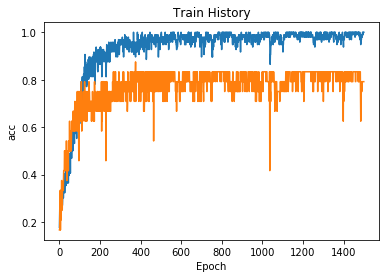

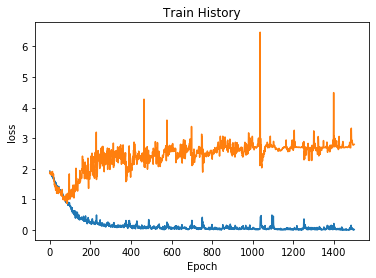

10/10 [==============================] - 0s 196us/step
Accuracy: 0.5%


array([[3, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0]], dtype=int64)

In [5]:

import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.show()

show_train_history(train_history, "acc", "val_acc") ## 訓練正確率圖

show_train_history(train_history, "loss", "val_loss") ## 訓練誤差圖

###############################


scores = model_m.evaluate(x_test_used, y_test_used_oneshot)

print("Accuracy: {}%".format(scores[1]))


results = model_m.predict_classes(x_test_used)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train[121:,], results)
cm